# Installing Dependencies

In [1]:
!pip install torchmetrics mlflow optuna pyngrok --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.7/931.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalle

# Importing Libraries

In [2]:
# For loading the data
import os
from google.colab import userdata
from zipfile import ZipFile

# For getting data in the right format
import pandas as pd

# For finding vocabulary of textual data
import spacy
from collections import Counter

# For viewing and preprocessing images
from PIL import Image

# For Dataset and Data Loading
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

# For train test split of data
import shutil
from sklearn.model_selection import train_test_split

# For plotting images
import matplotlib.pyplot as plt

# For model architecture
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# For training loop
from tqdm import tqdm
from torchmetrics.text import BLEUScore, ROUGEScore

# For hyperparameter tuning and experiment tracking
import optuna
import mlflow.pytorch
from pyngrok import ngrok

# For Learning rate scheduling
import torch.optim.lr_scheduler as lr_scheduler

# Loading the Dataset

In [3]:
data_path = '/kaggle/input/flickr8k'
caption_file = data_path + '/captions.txt'
df = pd.read_csv(caption_file)
print("No. of (Image, Caption) pairs: ", len(df))
df.head(10)

No. of (Image, Caption) pairs:  40455


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

**As we can see here, our dataset has for every image, 5 different captions**

# Data Preprocessing

In [4]:
spacy_eng = spacy.load("en_core_web_sm")

# Spacy tokenization example
text = "Skill Assessment Model: Validates and assesses skills from resumes, certifications, or projects. This resume parsing is done in a 2 step process - Performs OCR on user's resume to extract text, then uses Groq models to extract user data in json format for storage in database and user profile creation"
print([token.text.lower() for token in spacy_eng.tokenizer(text)])

['skill', 'assessment', 'model', ':', 'validates', 'and', 'assesses', 'skills', 'from', 'resumes', ',', 'certifications', ',', 'or', 'projects', '.', 'this', 'resume', 'parsing', 'is', 'done', 'in', 'a', '2', 'step', 'process', '-', 'performs', 'ocr', 'on', 'user', "'s", 'resume', 'to', 'extract', 'text', ',', 'then', 'uses', 'groq', 'models', 'to', 'extract', 'user', 'data', 'in', 'json', 'format', 'for', 'storage', 'in', 'database', 'and', 'user', 'profile', 'creation']


## Vocabulary Class

In [5]:
class Vocabulary:
  def __init__(self, min_freq):
    # Making a dictionary that maps integers to tokens
    # Adding the pre-defined special tokens
    self.int_to_str = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

    # Making the reverse dictionary as well
    self.str_to_int = {v:k for k, v in self.int_to_str.items()}

    # Minimum no. of occurances a word needs to have to add it in vocabulary
    self.freq_threshold = min_freq

  def __len__(self):
    """Returns the length of the vocabulary"""
    return len(self.int_to_str)

  def tokenize_text(self, text):
    """Tokenizes a body of text"""
    return [token.text.lower() for token in spacy_eng.tokenizer(text)]

  def build_vocab(self, sentence_list):
    """Builds the vocabulary for a list of sentences"""
    frequencies = Counter()
    idx = 4  # indices 0-3 were already filled by the special tokens before

    for sentence in sentence_list:
      for word in self.tokenize_text(sentence):
        frequencies[word] += 1

        # Adding the word to the vocabulary
        if frequencies[word] == self.freq_threshold:
          self.str_to_int[word] = idx
          self.int_to_str[idx] = word
          idx += 1

  def numericalize(self, text):
    """Returns a list of indices of each token from input text in vocab"""
    tokenized_text = self.tokenize_text(text)
    return [self.str_to_int[token] if token in self.str_to_int else self.str_to_int["<UNK>"] for token in tokenized_text]

In [6]:
# Testing the vocabulary class
vocab = Vocabulary(min_freq=1)
vocab.build_vocab([text])
print(text)
print(vocab.str_to_int)
print(vocab.numericalize(text))

Skill Assessment Model: Validates and assesses skills from resumes, certifications, or projects. This resume parsing is done in a 2 step process - Performs OCR on user's resume to extract text, then uses Groq models to extract user data in json format for storage in database and user profile creation
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'skill': 4, 'assessment': 5, 'model': 6, ':': 7, 'validates': 8, 'and': 9, 'assesses': 10, 'skills': 11, 'from': 12, 'resumes': 13, ',': 14, 'certifications': 15, 'or': 16, 'projects': 17, '.': 18, 'this': 19, 'resume': 20, 'parsing': 21, 'is': 22, 'done': 23, 'in': 24, 'a': 25, '2': 26, 'step': 27, 'process': 28, '-': 29, 'performs': 30, 'ocr': 31, 'on': 32, 'user': 33, "'s": 34, 'to': 35, 'extract': 36, 'text': 37, 'then': 38, 'uses': 39, 'groq': 40, 'models': 41, 'data': 42, 'json': 43, 'format': 44, 'for': 45, 'storage': 46, 'database': 47, 'profile': 48, 'creation': 49}
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 17, 18, 19, 20, 

## Dataset Class

In [7]:
class FlickrDataset(Dataset):
  """
  FlickrDataset
  """
  def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
    self.root_dir = root_dir
    self.df = pd.read_csv(captions_file)
    self.transform=transform

    self.imgs=self.df['image']
    self.captions=self.df['caption']

    self.vocab = Vocabulary(min_freq=freq_threshold)
    self.vocab.build_vocab(self.captions.to_list())

  def __len__(self):
    """Returns the no. of (image, caption) pairs"""
    return len(self.df)

  def __getitem__(self, idx):
    """Returns the img and caption at given idx"""
    caption = self.captions[idx]
    img_name = self.imgs[idx]
    img_location = os.path.join(self.root_dir, img_name)
    img = Image.open(img_location).convert("RGB")

    if self.transform is not None:
      img = self.transform(img)

    caption_vec = []
    caption_vec += [self.vocab.str_to_int["<SOS>"]]
    caption_vec += self.vocab.numericalize(caption)
    caption_vec += [self.vocab.str_to_int["<EOS>"]]

    return img, torch.tensor(caption_vec)

# Collate class for Dataloader


In [8]:
class capsCollate:
  """
  Apply padding to captions with less length
  """
  def __init__(self, pad_idx, batch_first=False):
    self.pad_idx = pad_idx  # index of <PAD> token in our vocabulary
    self.batch_first = batch_first  # whether image is batch_size,C,H,W or C,H,W,batch_size

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch]    # Adding an extra dimension (batch) to the images
    imgs = torch.cat(imgs, dim=0)   # Stacking the images across the 'batch' dimension

    targets = [item[1] for item in batch]   # Extracting captions
    targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx) # Adding padding to the captions

    return imgs, targets

# CNN + LSTM with Bahdanau Attention

## Dataset and Transforms

In [9]:
# Image Transforms
img_transforms = transforms.Compose([
  transforms.Resize(226),
  transforms.RandomCrop(224),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # values of normalization as used in ImageNet dataset - so models like ResNet, VGG perform better with this type of normalization rather than just dividing by 255.0. First tuple shows mean of RGB channels and second tuple shows standard deviation of the same
])

data_path="/kaggle/input/flickr8k"
train_dir = os.path.join(data_path, "train")
test_dir = os.path.join(data_path, "test")

# Dataset
dataset = FlickrDataset(
    root_dir = os.path.join("/content/flickr8k", "images"),
    captions_file = os.path.join(data_path, "captions.txt"),
    transform = img_transforms
)

## Model Architecture

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
class Encoder(nn.Module):
  def __init__(self, embed_size, dropout_prob):
    super(Encoder, self).__init__()
    resnet = models.resnet50(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad_(False)

    modules = list(resnet.children())[:-2]  # Removing the final 2 layers - the classifier and the global pooling. These are removed so that instead of receiving output in a 1D and losing all the spatial information, we instead extract the 2D feature map to use in for attention mechanism. Previosly, we extracted simply [batch_size, embed_size] dims data
    self.resnet = nn.Sequential(*modules)


  def forward(self, images):
    # images is [batch_size, num_channels, height, width] -> [batch_size, 3, 224, 224]
    features = self.resnet(images)    # features is [batch_size, 2048, 7, 7]  -> 7 is the resolution/ (height and width) -> 7,7 is the size of our feature map and 2048 is the number of channels
    features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
    features = features.reshape(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
    return features

In [12]:
class Attention(nn.Module):
  def __init__(self, encoder_dim, decoder_dim, attention_dim):
    super(Attention, self).__init__()
    self.encoderAtt = nn.Linear(encoder_dim, attention_dim)    # Transform encoder features
    self.decoderAtt = nn.Linear(decoder_dim, attention_dim)    # Transform decoder hidden_state
    self.fullAtt = nn.Linear(attention_dim, 1)   # Score for each region
    self. softmax = nn.Softmax(dim=1)  # To normalize score b/w 0 and 1

  def forward(self, encoder_features, hidden_state):
    # encoder features -> [batch_size, num_regions, encoder_dim] -> num_regions = w*h = 10*10 = 100
    # hidden_state = [batch_size, decoder_dim]

    encoderAttention = self.encoderAtt(encoder_features)  # [batch_size, num_regions, decoder_dim]
    decoderAttention = self.decoderAtt(hidden_state).unsqueeze(1)  # [batch_size, 1, decoder_dim]
    fullAttention = self.fullAtt(torch.tanh(encoderAttention + decoderAttention)) # [batch_size, num_regions, 1]
    fullAttention = fullAttention.squeeze(2)
    attention_weights = self.softmax(fullAttention)   # Attention scores   [batch_size, num_regions, 1]

    attention_weighted_encoding = (encoder_features*attention_weights.unsqueeze(2)).sum(dim=1)  # Final encoding [batch_size, encoder_dim]
    return attention_weights, attention_weighted_encoding

In [13]:
class Decoder(nn.Module):
  def __init__(self, embed_size, vocab_size, hidden_dim, num_layers, dropout_prob, encoder_dim, attention_dim):
    super().__init__()
    self.attention_dim = attention_dim
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.attention = Attention(encoder_dim, hidden_dim, attention_dim)
    self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, hidden_dim, bias=True)
    self.fc = nn.Linear(hidden_dim, vocab_size)
    self.dropout = nn.Dropout(p=dropout_prob)
    self.hidden_dim = hidden_dim
    self.num_layers=num_layers
    self.init_h = nn.Linear(encoder_dim, hidden_dim)
    self.init_c = nn.Linear(encoder_dim, hidden_dim)
    self.vocab_size=vocab_size

  def forward(self, encoder_features, captions):
    # encoder features [batch_size, num_regions, encoder_dim]
    # captions [batch_size, sequence_length]

    batch_size, _, encoder_dim = encoder_features.shape

    h, c = self.init_hidden_state(encoder_features)  # (batch_size, decoder_dim)

    outputs = []
    seq_length = len(captions[0])-1
    embeds = self.embedding(captions)  # [batch_size, sequence_length, embed_size]
    preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
    num_features = encoder_features.size(1)
    attention_weights = torch.zeros(batch_size, seq_length, num_features).to(device)

    for s in range(seq_length):   # Going till last word of caption i.e. excluding <EOS>
      # context_vector, attention_weights = self.attention(encoder_features, layer_hidden_states[0])
      attention_weight, context_vector = self.attention(encoder_features, h)

      # context vector -> [batch_size, encoder_dim], hidden state -> [batch_size, hidden_dim]
      lstm_input = torch.cat((embeds[:, s], context_vector), dim=1)
      h, c = self.lstm_cell(lstm_input, (h, c))

      output = self.fc(self.dropout(h)) # [batch_size, vocab_size]
      preds[:,s] = output
      attention_weights[:,s] = attention_weight

    return preds, attention_weights


  def generate_captions(self, encoder_features, vocab, max_len=20):
    # encoder_features -> [num_regions, encoder_dim]
    batch_size, _, encoder_dim = encoder_features.shape
    attention_weights = []

    word = torch.tensor(vocab.str_to_int['<SOS>']).view(1,-1).to(device)
    h, c = self.init_hidden_state(encoder_features)  # (batch_size, decoder_dim)
    embeds = self.embedding(word)

    captions = []
    for _ in range(max_len):
      # input_embed = self.embedding(input) # input_embed -> [1, embed_size]
      attention_weight, context_vector = self.attention(encoder_features, h)
      # context vector -> [1, encoder_dim]
      attention_weights.append(attention_weight.cpu().detach().numpy())
      lstm_input = torch.cat((embeds[:, 0], context_vector), dim=1)   # [1, embed_size + encoder_dim]
      h, c = self.lstm_cell(lstm_input, (h, c))

      output = self.fc(self.dropout(h))   # [1, vocab_size]
      output.view(batch_size, -1)

      predicted_word_idx = output.argmax(dim=1)  # [1]   -> index of the predicted word
      captions.append(predicted_word_idx.item())
      if vocab.int_to_str[predicted_word_idx.item()] == '<EOS>':
        break

      embeds = self.embedding(predicted_word_idx.unsqueeze(0))

    return [vocab.int_to_str[word] for word in captions], attention_weights

  def init_hidden_state(self, encoder_out):
    mean_encoder_out = encoder_out.mean(dim=1)
    h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
    c = self.init_c(mean_encoder_out)
    return h, c

In [14]:
class EncoderDecoderUsingAttention(nn.Module):
  def __init__(self, embed_size, vocab_size, hidden_dim, num_layers, dropout_prob, encoder_dim, attention_dim):
    super(EncoderDecoderUsingAttention, self).__init__()
    self.encoder = Encoder(embed_size, dropout_prob)
    self.decoder = Decoder(embed_size, vocab_size, hidden_dim, num_layers, dropout_prob, encoder_dim, attention_dim)

  def forward(self, images, captions):
    features = self.encoder(images)   # features is [batch_size, num_regions=49, embed_size]
    outputs = self.decoder(features, captions)
    return outputs

## Model Training

In [15]:
def show_image(inp, title=None):
  """ imshow for tensor """
  inp = inp.numpy().transpose((1, 2, 0))  # converting pytorch image format (C, H, W) -> matplotlib format (H, W, C)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pausing a bit to update the plots

In [16]:
def training_loop(BATCH_SIZE):
  img_transforms = transforms.Compose([
    transforms.Resize(226),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # values of normalization as used in ImageNet dataset - so models like ResNet, VGG perform better with this type of normalization rather than just dividing by 255.0. First tuple shows mean of RGB channels and second tuple shows standard deviation of the same
  ])

  dataset = FlickrDataset(
    root_dir = os.path.join("/kaggle/input/flickr8k", "Images"),
    captions_file = os.path.join("/kaggle/input/flickr8k", "captions.txt"),
    transform = img_transforms
  )
  vocab_curr = dataset.vocab

  BATCH_SIZE = BATCH_SIZE
  NUM_WORKER = 4

  pad_idx = dataset.vocab.str_to_int["<PAD>"]

  data_loader = DataLoader(
      dataset=dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKER,
      shuffle=True,
      collate_fn=capsCollate(pad_idx=pad_idx, batch_first=True)
  )

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  model = EncoderDecoderUsingAttention(
      embed_size=300,
      vocab_size=len(vocab_curr),
      hidden_dim=512,
      num_layers=1,
      dropout_prob=0.2,
      encoder_dim=2048,
      attention_dim=256
  ).to(device)
  loss_fn = nn.CrossEntropyLoss(ignore_index=vocab_curr.str_to_int['<PAD>'])
  optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
  bleu_metric = BLEUScore(n_gram=2, smooth=True)
  rouge_metric = ROUGEScore()
  vocab_size=len(vocab_curr)

  num_epochs = 30
  Results = {}
  best_loss = 1e9

  for epoch in tqdm(range(num_epochs)):
      print(f"\nEpoch: {epoch}\n-----")

      model.train()
      loss, bleu, rouge = 0, 0, 0

      for batch, (images, captions) in enumerate(iter(data_loader)):
          images, captions = images.to(device), captions.to(device)

          # Forward pass: model returns outputs with shape [batch_size, seq_length, vocab_size]
          outputs, attentions = model(images, captions)

          # Compute loss
          train_loss = loss_fn(outputs.view(-1, vocab_size), captions[:, 1:].reshape(-1))
          loss += train_loss.item()

          optimizer.zero_grad()
          train_loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
          optimizer.step()

          # Inference on the current batch
          model.eval()
          with torch.inference_mode():
              # Get encoder features and reshape: [1, embed_size, h, w] -> [1, num_regions, embed_size]
              features = model.encoder(images[0:1])

              # Generate caption from features
              pred_caption, attention_weights = model.decoder.generate_captions(features, vocab=vocab_curr)
              pred_caption_str = ' '.join(pred_caption)

              # Construct the true caption string (skip <PAD> tokens)
              true_tokens = [vocab_curr.int_to_str[idx.item()]
                            for idx in captions[0]
                            if idx.item() != vocab_curr.str_to_int['<PAD>']]
              true_caption_str = ' '.join(true_tokens)

              bleu_score = bleu_metric([pred_caption_str], [true_caption_str]).item()
              bleu += bleu_score
              rouge_scores = rouge_metric(pred_caption_str, true_caption_str)
              rouge += rouge_scores["rougeL_fmeasure"].item()

      loss /= len(data_loader)
      bleu /= len(data_loader)
      rouge /= len(data_loader)

      with torch.inference_mode():
        dataiter = iter(data_loader)
        img, _ = next(dataiter)
        single_image = img[0:1].to(device)
        features = model.encoder(single_image)
        caps, atts = model.decoder.generate_captions(features, vocab=vocab_curr)
        caption = ' '.join(caps)
        print(f"Caption: {caption}\n")
        show_image(img[0], title=caption)

        Results[f"Epoch {epoch}"] = {
            "Train Loss": loss,
            "Train BLEU": bleu,
            "Train ROUGE-L": rouge,
        }

      print(f"\nTrain Loss: {loss:.4f} | Train BLEU: {bleu:.4f} | Train ROUGE-L: {rouge:.4f}")

      scheduler.step(loss)

      if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved at epoch: ",epoch)

  return Results

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]
  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
-----
Caption: a man in a red and white and white and white and white and white . <EOS>



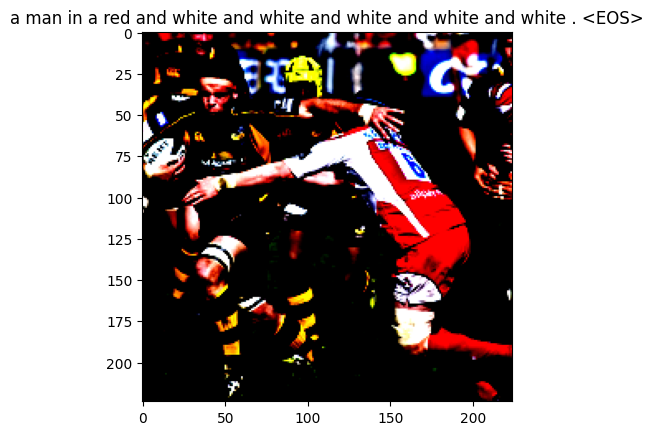


Train Loss: 4.5257 | Train BLEU: 0.0000 | Train ROUGE-L: 0.2741


  3%|▎         | 1/30 [02:36<1:15:48, 156.84s/it]

Best model saved at epoch:  0

Epoch: 1
-----
Caption: a man is jumping a <UNK> <UNK> . <EOS>



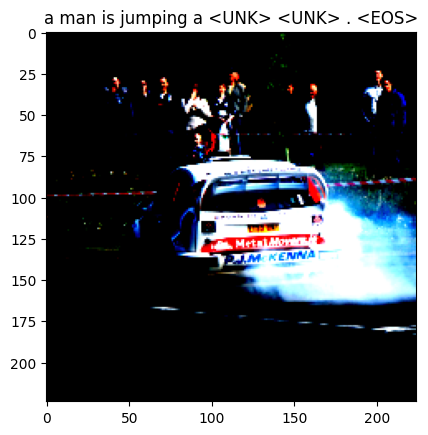


Train Loss: 3.5959 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3128


  7%|▋         | 2/30 [05:10<1:12:13, 154.76s/it]

Best model saved at epoch:  1

Epoch: 2
-----
Caption: a young boy in a red shirt and a red shirt and a red and white and white and white



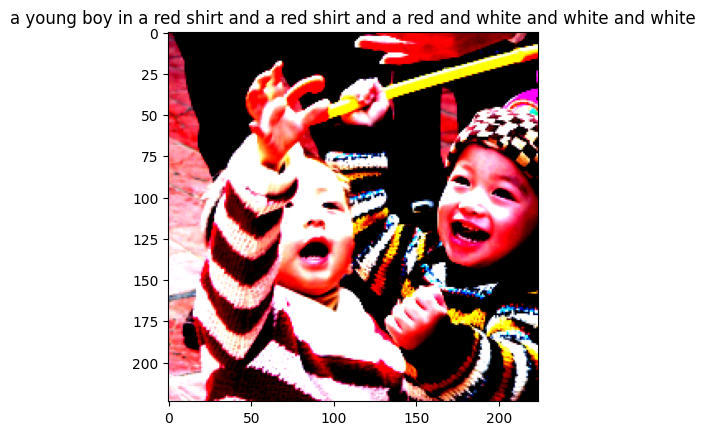


Train Loss: 3.2319 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3121


 10%|█         | 3/30 [07:43<1:09:20, 154.08s/it]

Best model saved at epoch:  2

Epoch: 3
-----
Caption: two dogs are running through the water . <EOS>



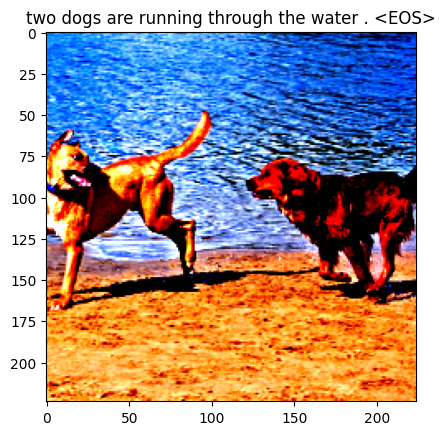


Train Loss: 3.0144 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3332


 13%|█▎        | 4/30 [10:17<1:06:50, 154.24s/it]

Best model saved at epoch:  3

Epoch: 4
-----
Caption: a young boy in a blue shirt is standing on the beach . <EOS>



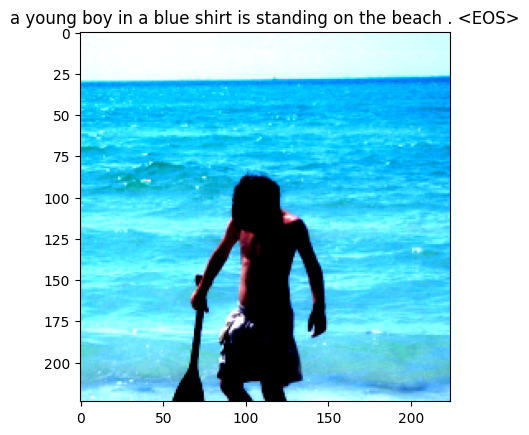


Train Loss: 2.8749 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3339


 17%|█▋        | 5/30 [12:54<1:04:33, 154.94s/it]

Best model saved at epoch:  4

Epoch: 5
-----
Caption: a dog runs in the air . <EOS>



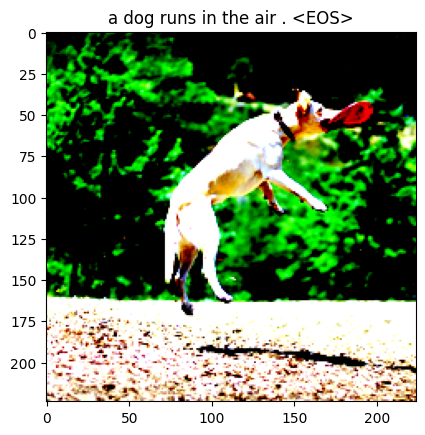


Train Loss: 2.7660 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3355


 20%|██        | 6/30 [15:30<1:02:14, 155.59s/it]

Best model saved at epoch:  5

Epoch: 6
-----
Caption: a man in a blue wetsuit is swimming in a pool . <EOS>



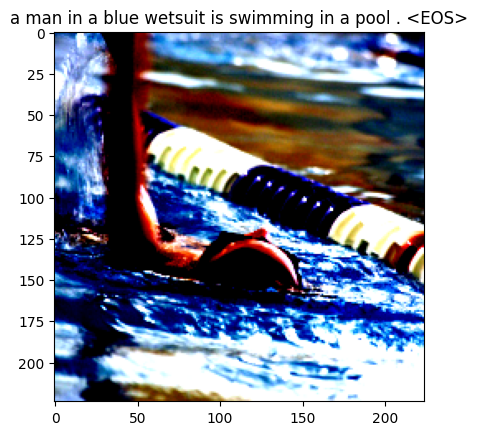


Train Loss: 2.6789 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3356


 23%|██▎       | 7/30 [18:09<1:00:03, 156.66s/it]

Best model saved at epoch:  6

Epoch: 7
-----
Caption: a man and a woman are sitting on a train . <EOS>



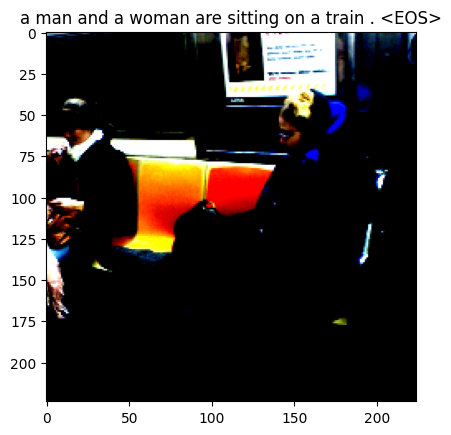


Train Loss: 2.6005 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3594


 27%|██▋       | 8/30 [20:50<57:56, 158.04s/it]  

Best model saved at epoch:  7

Epoch: 8
-----
Caption: a man in a black jacket and a black jacket is standing in front of a building . <EOS>



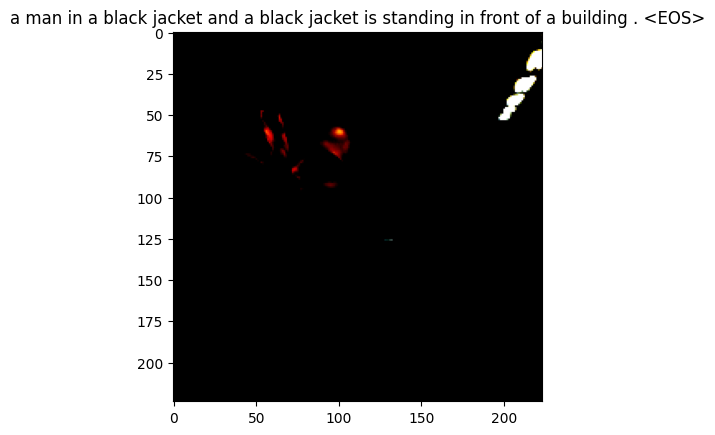


Train Loss: 2.5339 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3618


 30%|███       | 9/30 [23:36<56:06, 160.29s/it]

Best model saved at epoch:  8

Epoch: 9
-----
Caption: a man in a blue shirt is sitting on a trampoline . <EOS>



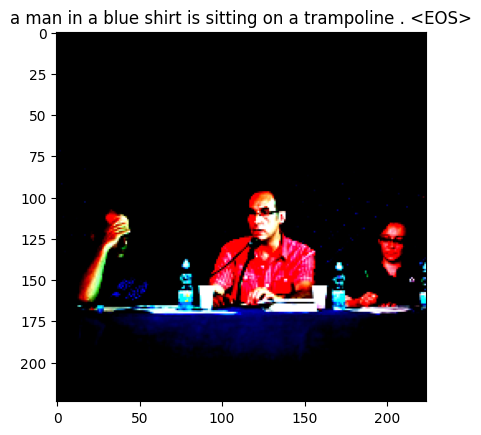


Train Loss: 2.4769 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3668


 33%|███▎      | 10/30 [26:22<54:01, 162.08s/it]

Best model saved at epoch:  9

Epoch: 10
-----
Caption: a girl is jumping into the air . <EOS>



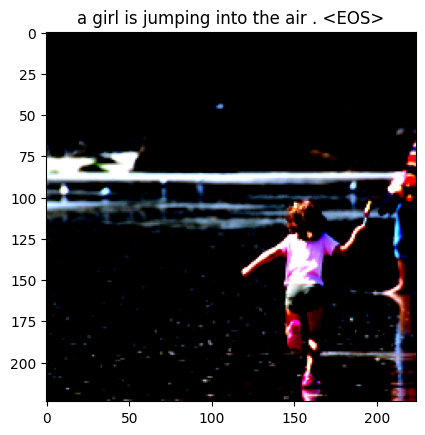


Train Loss: 2.4230 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3738


 37%|███▋      | 11/30 [29:10<51:58, 164.15s/it]

Best model saved at epoch:  10

Epoch: 11
-----
Caption: a black dog is running through the sand . <EOS>



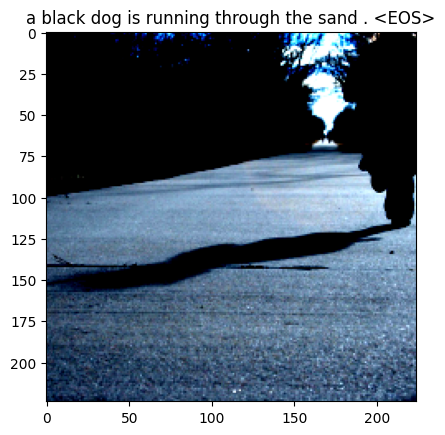


Train Loss: 2.3754 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3456


 40%|████      | 12/30 [32:01<49:49, 166.10s/it]

Best model saved at epoch:  11

Epoch: 12
-----
Caption: a man is climbing a rock face . <EOS>



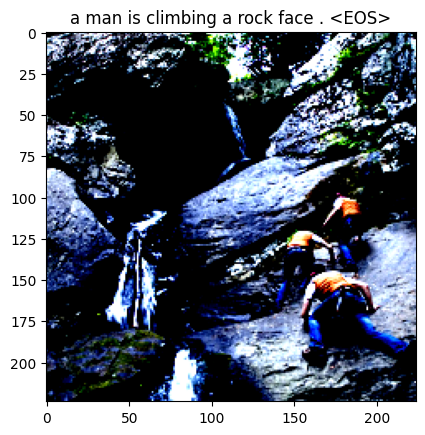


Train Loss: 2.3330 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3926


 43%|████▎     | 13/30 [34:55<47:41, 168.34s/it]

Best model saved at epoch:  12

Epoch: 13
-----
Caption: a scuba diver underwater . <EOS>



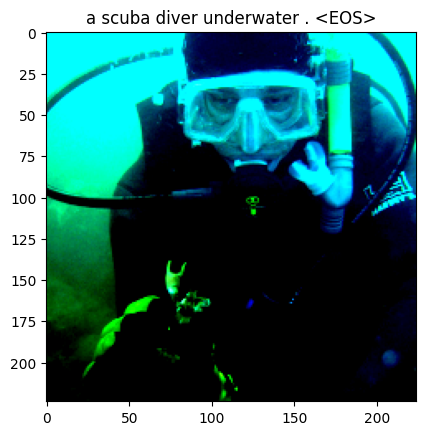


Train Loss: 2.2939 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3497


 47%|████▋     | 14/30 [37:50<45:29, 170.59s/it]

Best model saved at epoch:  13

Epoch: 14
-----
Caption: a boy is standing on a rock wall . <EOS>



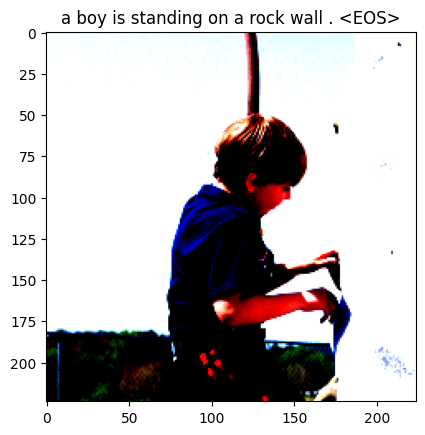


Train Loss: 2.2561 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3740


 50%|█████     | 15/30 [40:48<43:12, 172.85s/it]

Best model saved at epoch:  14

Epoch: 15
-----
Caption: a greyhound greyhound in a muzzle runs on a track . <EOS>



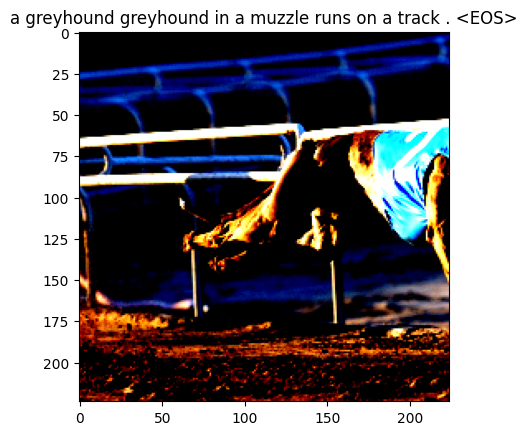


Train Loss: 2.2216 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3813


 53%|█████▎    | 16/30 [43:47<40:44, 174.61s/it]

Best model saved at epoch:  15

Epoch: 16
-----
Caption: a dog with a collar is standing in the sand . <EOS>



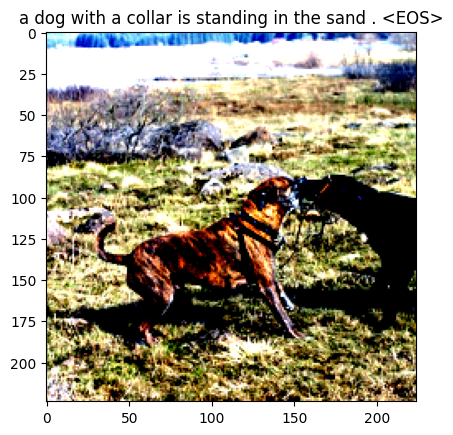


Train Loss: 2.1875 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3640


 57%|█████▋    | 17/30 [46:48<38:16, 176.62s/it]

Best model saved at epoch:  16

Epoch: 17
-----
Caption: a dog jumps to catch a ball in its mouth . <EOS>



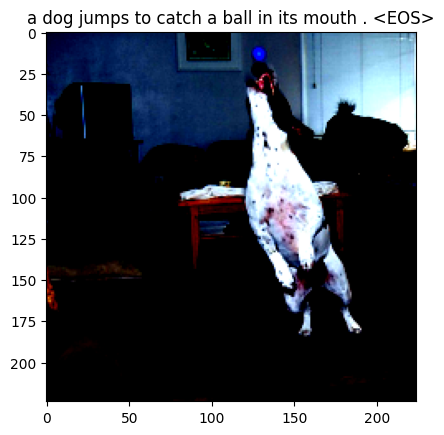


Train Loss: 2.1579 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3793


 60%|██████    | 18/30 [49:53<35:47, 178.99s/it]

Best model saved at epoch:  17

Epoch: 18
-----
Caption: a bike rider is jumping over a dirt road . <EOS>



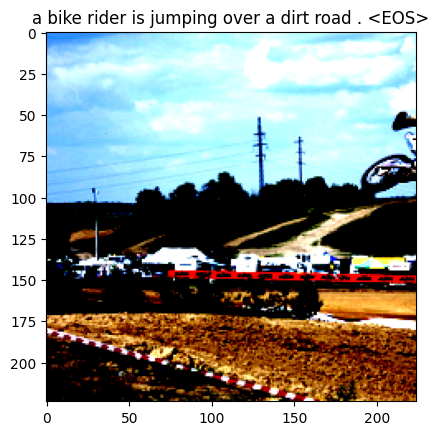


Train Loss: 2.1283 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3872


 63%|██████▎   | 19/30 [53:00<33:15, 181.41s/it]

Best model saved at epoch:  18

Epoch: 19
-----
Caption: two dogs are playing with a stick in the grass . <EOS>



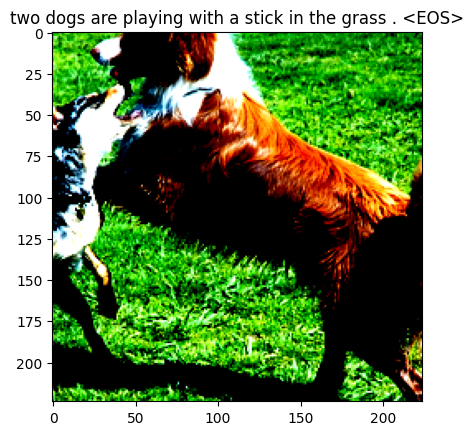


Train Loss: 2.0965 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3866


 67%|██████▋   | 20/30 [56:09<30:37, 183.74s/it]

Best model saved at epoch:  19

Epoch: 20
-----
Caption: a man and a woman are walking on the sidewalk . <EOS>



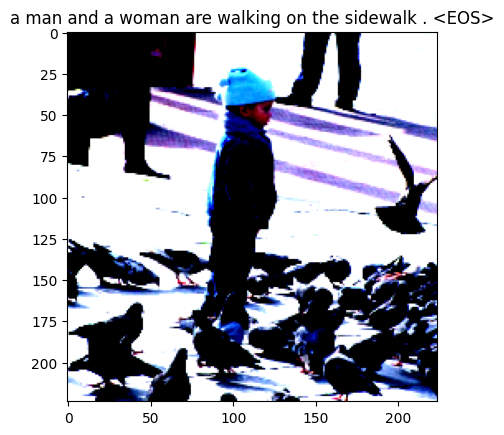


Train Loss: 2.0692 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3959


 70%|███████   | 21/30 [59:21<27:54, 186.09s/it]

Best model saved at epoch:  20

Epoch: 21
-----
Caption: a dog is running through a river . <EOS>



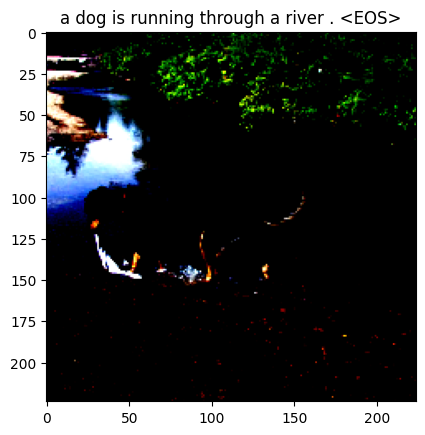


Train Loss: 2.0431 | Train BLEU: 0.0000 | Train ROUGE-L: 0.3904


 73%|███████▎  | 22/30 [1:02:35<25:08, 188.59s/it]

Best model saved at epoch:  21

Epoch: 22
-----
Caption: a woman is walking on a sidewalk with a fishing pole in the background . <EOS>



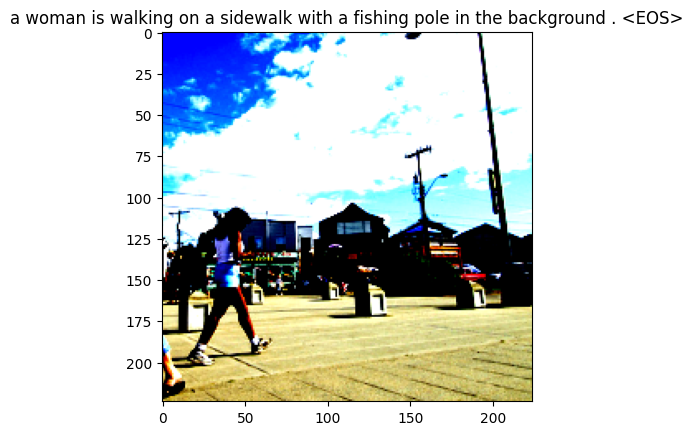


Train Loss: 2.0202 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4165


 77%|███████▋  | 23/30 [1:05:53<22:19, 191.43s/it]

Best model saved at epoch:  22

Epoch: 23
-----
Caption: two black dogs are playing with a green toy . <EOS>



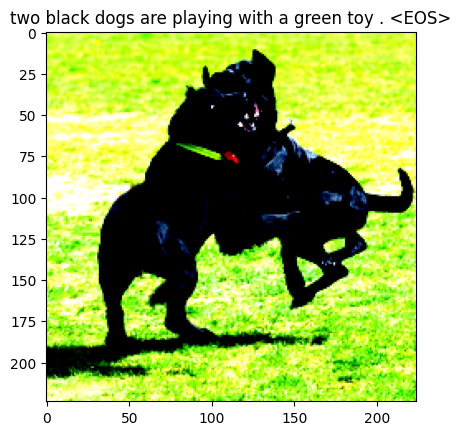


Train Loss: 1.9959 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4045


 80%|████████  | 24/30 [1:09:13<19:22, 193.82s/it]

Best model saved at epoch:  23

Epoch: 24
-----
Caption: a woman in a yellow shirt on a merry - round - round - round - round - round -



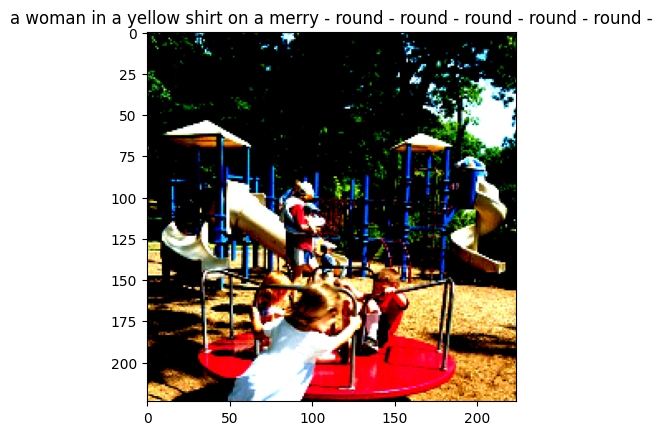


Train Loss: 1.9695 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4164


 83%|████████▎ | 25/30 [1:12:35<16:21, 196.30s/it]

Best model saved at epoch:  24

Epoch: 25
-----
Caption: a man in a black coat and a black hat is standing in front of a tree . <EOS>



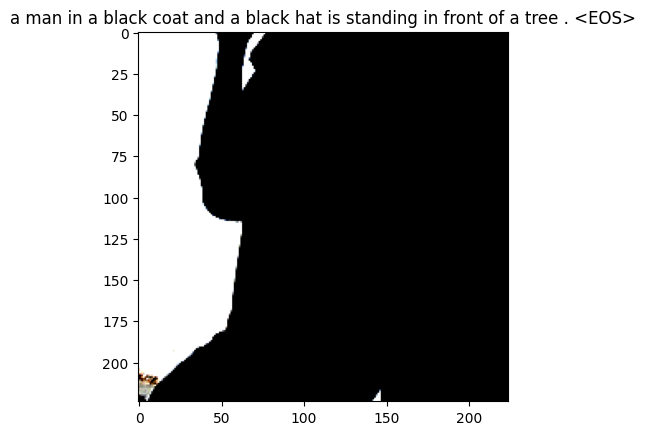


Train Loss: 1.9476 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4193


 87%|████████▋ | 26/30 [1:15:56<13:11, 197.84s/it]

Best model saved at epoch:  25

Epoch: 26
-----
Caption: a young boy is jumping over a chain at the beach . <EOS>



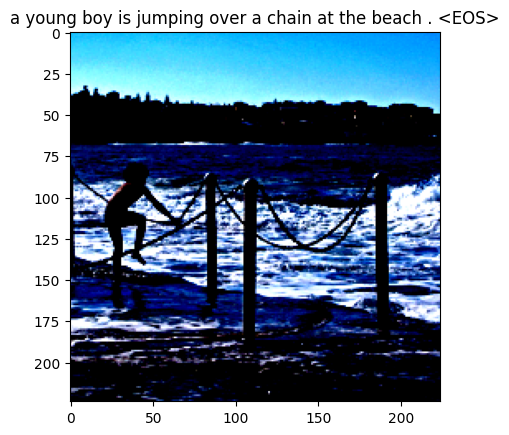


Train Loss: 1.9281 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4065


 90%|█████████ | 27/30 [1:19:21<09:59, 199.96s/it]

Best model saved at epoch:  26

Epoch: 27
-----
Caption: a brown dog is running in the grass . <EOS>



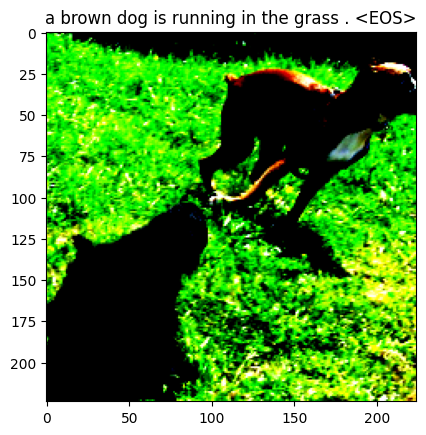


Train Loss: 1.9054 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4139


 93%|█████████▎| 28/30 [1:22:47<06:43, 201.79s/it]

Best model saved at epoch:  27

Epoch: 28
-----
Caption: a black and white dog is chasing a sheep . <EOS>



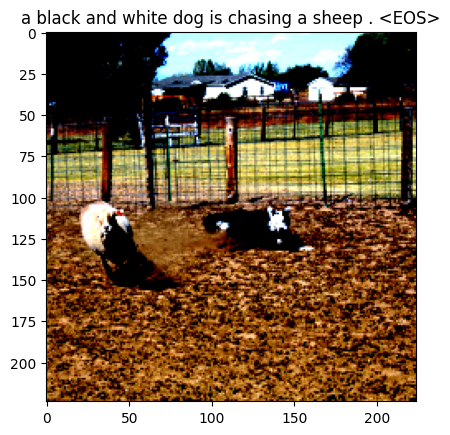


Train Loss: 1.8841 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4161


 97%|█████████▋| 29/30 [1:26:15<03:23, 203.64s/it]

Best model saved at epoch:  28

Epoch: 29
-----
Caption: a man and a woman smile for a picture . <EOS>



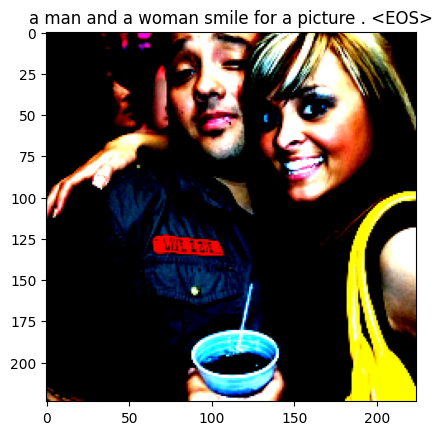


Train Loss: 1.8665 | Train BLEU: 0.0000 | Train ROUGE-L: 0.4191


100%|██████████| 30/30 [1:29:46<00:00, 179.55s/it]

Best model saved at epoch:  29


In [17]:
Results = training_loop(BATCH_SIZE=256)

In [18]:
results = pd.DataFrame(Results).T
results.to_csv('results.csv')
res = pd.read_csv('/content/results.csv')
res

FileNotFoundError: [Errno 2] No such file or directory: '/content/results.csv'